In [1]:
%pip install SoccerNet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.3 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
from SoccerNet.Downloader import SoccerNetDownloader as SNdl

# Set up the downloader
local_directory = "path/to/SoccerNet"
mySNdl = SNdl(LocalDirectory=local_directory)

# Download the data
mySNdl.downloadDataTask(task="mvfouls", split=["train", "valid", "test", "challenge"], password="pass")

# Unzip the downloaded files
task_directory = os.path.join(local_directory, "mvfouls")
for split in ["train", "valid", "test", "challenge"]:
    zip_file = os.path.join(task_directory, f"{split}.zip")
    if os.path.exists(zip_file):
        # Create a new folder with the same name as the zip file
        extract_folder = os.path.join(task_directory, split)
        os.makedirs(extract_folder, exist_ok=True)

        # Extract the contents to the new folder
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
        print(f"Extracted {split}.zip to {extract_folder}")
    else:
        print(f"{split}.zip not found")

# Optionally, remove the zip files after extraction
for split in ["train", "valid", "test", "challenge"]:
    zip_file = os.path.join(task_directory, f"{split}.zip")
    if os.path.exists(zip_file):
        os.remove(zip_file)
        print(f"Removed {split}.zip")

Extracted train.zip to path/to/SoccerNet/mvfouls/train
Extracted valid.zip to path/to/SoccerNet/mvfouls/valid
Extracted test.zip to path/to/SoccerNet/mvfouls/test
Extracted challenge.zip to path/to/SoccerNet/mvfouls/challenge
Removed train.zip
Removed valid.zip
Removed test.zip
Removed challenge.zip


In [2]:
# Class name to label index

EVENT_DICTIONARY_action_class = {"Tackling":0,"Standing tackling":1,"High leg":2,"Holding":3,"Pushing":4,
                        "Elbowing":5, "Challenge":6, "Dive":7, "Dont know":8}

INVERSE_EVENT_DICTIONARY_action_class = {0:"Tackling", 1:"Standing tackling", 2:"High leg", 3:"Holding", 4:"Pushing",
                        5:"Elbowing", 6:"Challenge", 7:"Dive", 8:"Dont know"}


EVENT_DICTIONARY_offence_severity_class = {"No offence":0,"Offence + No card":1,"Offence + Yellow card":2,"Offence + Red card":3}

INVERSE_EVENT_DICTIONARY_offence_severity_class = {0:"No offence", 1:"Offence + No card", 2:"Offence + Yellow card", 3:"Offence + Red card"}


EVENT_DICTIONARY_offence_class = {"Offence":0,"Between":1,"No Offence":2, "No offence":2}

INVERSE_EVENT_DICTIONARY_offence_class = {0:"Offence", 1:"Between", 2:"No Offence"}


EVENT_DICTIONARY_severity_class = {"1.0":0,"2.0":1,"3.0":2,"4.0":3,"5.0":4}

INVERSE_EVENT_DICTIONARY_severity_class = {0:"No card", 1:"Borderline No/Yellow", 2:"Yellow card", 3:"Borderline Yellow/Red", 4:"Red card"}


EVENT_DICTIONARY_bodypart_class = {"Upper body":0,"Under body":1}

INVERSE_EVENT_DICTIONARY_bodypart_class = {0:"Upper body", 1:"Under body"}



EVENT_DICTIONARY = {'action_class':EVENT_DICTIONARY_action_class, 'offence_class': EVENT_DICTIONARY_offence_class,
            'severity_class': EVENT_DICTIONARY_severity_class, 'bodypart_class': EVENT_DICTIONARY_bodypart_class, 'offence_severity_class': EVENT_DICTIONARY_offence_severity_class}
INVERSE_EVENT_DICTIONARY = {'action_class':INVERSE_EVENT_DICTIONARY_action_class, 'offence_class': INVERSE_EVENT_DICTIONARY_offence_class,
            'severity_class': INVERSE_EVENT_DICTIONARY_severity_class, 'bodypart_class': INVERSE_EVENT_DICTIONARY_bodypart_class, 'offence_severity_class': INVERSE_EVENT_DICTIONARY_offence_severity_class}

In [3]:
import os
import torch
import json
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DATA_PATH = 'path/to/SoccerNet/mvfouls'

# Set the desired frame count
DESIRED_FRAME_COUNT = 16

# Load the EVENT_DICTIONARY for mapping annotation labels
EVENT_DICTIONARY = {
    'action_class': {"Tackling": 0, "Standing tackling": 1, "High leg": 2, "Holding": 3, "Pushing": 4,
                     "Elbowing": 5, "Challenge": 6, "Dive": 7, "Dont know": 8},
    'offence_class': {"Offence": 0, "Between": 1, "No Offence": 2, "No offence": 2},
    'severity_class': {"1.0": 0, "2.0": 1, "3.0": 2, "4.0": 3, "5.0": 4},
    'bodypart_class': {"Upper body": 0, "Under body": 1},
    'offence_severity_class': {"No offence": 0, "Offence + No card": 1, "Offence + Yellow card": 2, "Offence + Red card": 3}
}

# Transformation for preprocessing
transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_filtered_clips_and_labels(DATA_PATH,split, max_samples):
    clips, labels_action, labels_offence, labels_severity, labels_bodypart, labels_offence_severity = [], [], [], [], [], []

    annotations_path = os.path.join(DATA_PATH, split, "annotations.json")
    print(f"Loading annotations from: {annotations_path}")

    with open(annotations_path, 'r') as f:
        annotations = json.load(f)
    print(f"Total actions found in annotations: {len(annotations['Actions'])}")

    offence_count, no_offence_count, skipped_actions = 0, 0, 0
    max_samples = max_samples  # Maximum samples for each class

    for action_index, (action_key, action_data) in enumerate(annotations['Actions'].items()):
        offence_class = action_data['Offence']

        # Filter only 50 samples for each class
        if (offence_class == "Offence" and offence_count >= max_samples) or \
           (offence_class in ["No offence", "No Offence"] and no_offence_count >= max_samples):
            continue

        action_class = action_data['Action class']
        severity_class = action_data['Severity'] if action_data['Severity'].replace('.', '').isdigit() else '1.0'
        bodypart_class = action_data.get('Bodypart', 'Upper body')
        offence_severity = f"{offence_class} + {EVENT_DICTIONARY['severity_class'].get(severity_class, 'No card')}"

        action_label = EVENT_DICTIONARY['action_class'].get(action_class)
        offence_label = EVENT_DICTIONARY['offence_class'].get(offence_class)
        severity_label = EVENT_DICTIONARY['severity_class'].get(severity_class)
        bodypart_label = EVENT_DICTIONARY['bodypart_class'].get(bodypart_class)
        offence_severity_label = EVENT_DICTIONARY['offence_severity_class'].get(offence_severity, 0)

        if None in [action_label, offence_label, severity_label, bodypart_label, offence_severity_label]:
            skipped_actions += 1
            continue

        action_folder = os.path.join(DATA_PATH, split, f"action_{action_key}")

        if not os.path.exists(action_folder):
            skipped_actions += 1
            continue

        action_clips = []
        for clip_idx in range(2):
            clip_path = os.path.join(action_folder, f"clip_{clip_idx}.mp4")
            if not os.path.exists(clip_path):
                continue

            cap = cv2.VideoCapture(clip_path)
            frames = []
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                frame = transform(frame)
                frames.append(frame)
            cap.release()

            # Sample or pad frames to ensure uniform frame count
            if len(frames) > DESIRED_FRAME_COUNT:
                indices = np.linspace(0, len(frames) - 1, DESIRED_FRAME_COUNT).astype(int)
                frames = [frames[i] for i in indices]
            elif len(frames) < DESIRED_FRAME_COUNT:
                frames += [frames[-1]] * (DESIRED_FRAME_COUNT - len(frames))

            video_tensor = torch.stack(frames, dim=0)
            action_clips.append(video_tensor)

            # Print tensor shape and size for debugging
            print(f"Action {action_key}, Clip {clip_idx} tensor shape: {video_tensor.shape}")
            tensor_size = video_tensor.element_size() * video_tensor.nelement() / (1024**2)
            print(f"Tensor size: {tensor_size:.2f} MB")

        if action_clips:
            clips.append(action_clips)
            labels_action.append(action_label)
            labels_offence.append(offence_label)
            labels_severity.append(severity_label)
            labels_bodypart.append(bodypart_label)
            labels_offence_severity.append(offence_severity_label)

            if offence_class == "Offence":
                offence_count += 1
            else:
                no_offence_count += 1

            print(f"Added action {action_key} with {len(action_clips)} clips to dataset.")

        # Stop if we have 50 samples for each class
        if offence_count >= max_samples and no_offence_count >= max_samples:
            break

    print("\nSummary:")
    print(f"Total actions loaded: {len(clips)}")
    print(f"Total actions skipped: {skipped_actions}")
    if clips:
        print(f"Example clip shape: {clips[0][0].shape}")
        print(f"First action label: {labels_action[0]}")

    return clips, labels_action, labels_offence, labels_severity, labels_bodypart, labels_offence_severity


# # Load datasets for each split
# datasets = {}
# for split in ['train', 'valid', 'test']:
#     clips, labels_action, labels_offence, labels_severity, labels_bodypart, labels_offence_severity = load_filtered_clips_and_labels(DATA_PATH,split)
#     datasets[split] = {
#         'clips': clips,
#         'labels': {
#             'action': labels_action,
#             'offence': labels_offence,
#             'severity': labels_severity,
#             'bodypart': labels_bodypart,
#             'offence_severity': labels_offence_severity
#         }
#     }

# # Display dataset info for verification
# for split in ['train', 'valid', 'test']:
#     print(f"{split.capitalize()} set:")
#     print("Number of samples:", len(datasets[split]['clips']))
#     print("Example label structure:", datasets[split]['labels']['action'][0] if datasets[split]['labels']['action'] else "No labels")


In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultiTaskActionRecognitionModel(nn.Module):
    def __init__(self, num_classes_action=9, num_classes_offence=3, num_classes_severity=5,
                 num_classes_bodypart=2, num_classes_offence_severity=4, freeze_backbone=True):
        super(MultiTaskActionRecognitionModel, self).__init__()

        # Load pretrained ResNet-18 3D backbone
        r3d_18 = models.video.r3d_18(pretrained=True)

        # Optionally freeze backbone layers
        if freeze_backbone:
            for param in r3d_18.parameters():
                param.requires_grad = False

        # Remove the last fully connected layer
        self.backbone = nn.Sequential(*list(r3d_18.children())[:-1])  # Output shape: [batch, 512, 1, 1, 1]

        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool3d(1)  # Output shape: [batch, 512, 1, 1, 1] -> [batch, 512]

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)

        # Define custom fully connected layers for each task
        self.fc_action = nn.Linear(512, num_classes_action)
        self.fc_offence = nn.Linear(512, num_classes_offence)
        self.fc_severity = nn.Linear(512, num_classes_severity)
        self.fc_bodypart = nn.Linear(512, num_classes_bodypart)
        self.fc_offence_severity = nn.Linear(512, num_classes_offence_severity)

    def forward(self, x):
        # Extract features using the backbone
        x = self.backbone(x)
        x = self.global_pool(x).view(x.size(0), -1)  # Global pooling and flattening

        # Apply dropout
        x = self.dropout(x)

        # Forward through task-specific fully connected layers
        action_out = self.fc_action(x)
        offence_out = self.fc_offence(x)
        severity_out = self.fc_severity(x)
        bodypart_out = self.fc_bodypart(x)
        offence_severity_out = self.fc_offence_severity(x)

        return action_out, offence_out, severity_out, bodypart_out, offence_severity_out


Loading annotations from: mvfouls\train\annotations.json
Total actions found in annotations: 2916
Action 0, Clip 0 tensor shape: torch.Size([16, 3, 56, 56])
Tensor size: 0.57 MB
Action 0, Clip 1 tensor shape: torch.Size([16, 3, 56, 56])
Tensor size: 0.57 MB
Added action 0 with 2 clips to dataset.
Action 19, Clip 0 tensor shape: torch.Size([16, 3, 56, 56])
Tensor size: 0.57 MB
Action 19, Clip 1 tensor shape: torch.Size([16, 3, 56, 56])
Tensor size: 0.57 MB
Added action 19 with 2 clips to dataset.

Summary:
Total actions loaded: 2
Total actions skipped: 0
Example clip shape: torch.Size([16, 3, 56, 56])
First action label: 6
Loading annotations from: mvfouls\valid\annotations.json
Total actions found in annotations: 411
Action 0, Clip 0 tensor shape: torch.Size([16, 3, 56, 56])
Tensor size: 0.57 MB
Action 0, Clip 1 tensor shape: torch.Size([16, 3, 56, 56])
Tensor size: 0.57 MB
Added action 0 with 2 clips to dataset.
Action 2, Clip 0 tensor shape: torch.Size([16, 3, 56, 56])
Tensor size: 0

c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\harka\miniconda3\

Epoch [1/2], Train Loss: 7.2563
Training Metrics: F1 {'action': 0.0, 'offence': 0.0, 'severity': 0.0, 'bodypart': 1.0, 'offence_severity': 0.0}, Recall {'action': 0.0, 'offence': 0.0, 'severity': 0.0, 'bodypart': 1.0, 'offence_severity': 0.0}, Accuracy {'action': 0.0, 'offence': 0.0, 'severity': 0.0, 'bodypart': 1.0, 'offence_severity': 0.0}


c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 6.5831
Validation Metrics: F1 {'action': 0.0, 'offence': 0.0, 'severity': 0.0, 'bodypart': 1.0, 'offence_severity': 1.0}, Recall {'action': 0.0, 'offence': 0.0, 'severity': 0.0, 'bodypart': 1.0, 'offence_severity': 1.0}, Accuracy {'action': 0.0, 'offence': 0.0, 'severity': 0.0, 'bodypart': 1.0, 'offence_severity': 1.0}


c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/2], Train Loss: 6.0462
Training Metrics: F1 {'action': 0.3333333333333333, 'offence': 0.3333333333333333, 'severity': 1.0, 'bodypart': 0.3333333333333333, 'offence_severity': 0.3333333333333333}, Recall {'action': 0.3333333333333333, 'offence': 0.3333333333333333, 'severity': 1.0, 'bodypart': 0.5, 'offence_severity': 0.25}, Accuracy {'action': 0.5, 'offence': 0.5, 'severity': 1.0, 'bodypart': 0.5, 'offence_severity': 0.5}


c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 6.3635
Validation Metrics: F1 {'action': 0.0, 'offence': 0.0, 'severity': 0.3333333333333333, 'bodypart': 1.0, 'offence_severity': 1.0}, Recall {'action': 0.0, 'offence': 0.0, 'severity': 0.5, 'bodypart': 1.0, 'offence_severity': 1.0}, Accuracy {'action': 0.0, 'offence': 0.0, 'severity': 0.5, 'bodypart': 1.0, 'offence_severity': 1.0}


c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


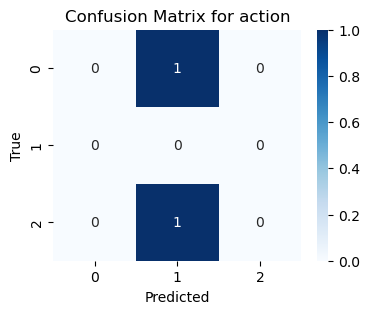

c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


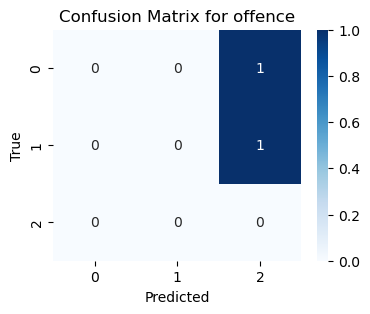

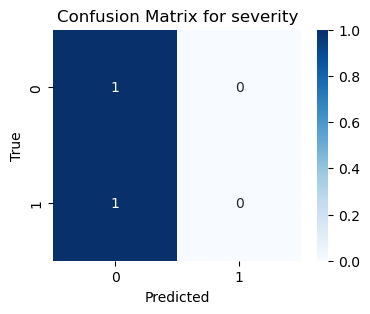

c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


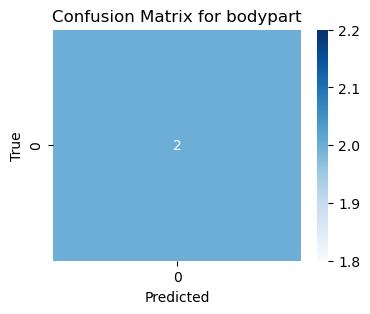

c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


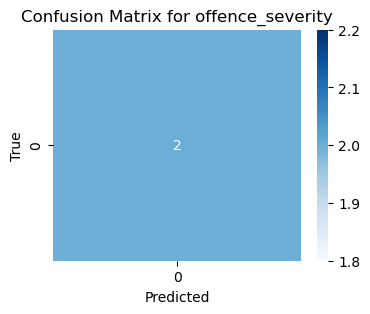

c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


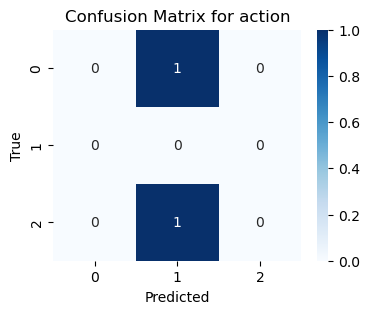

c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


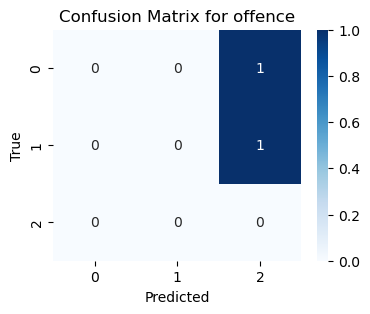

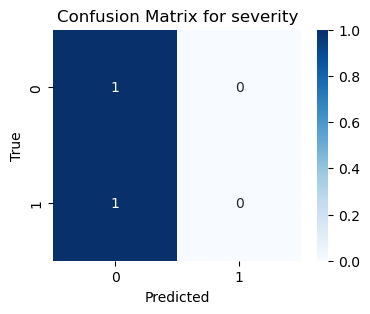

c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


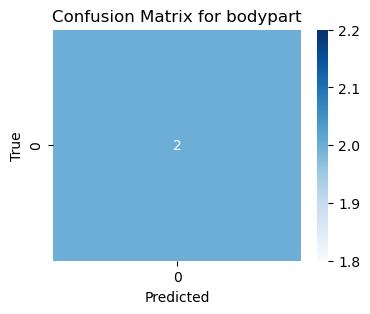

c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


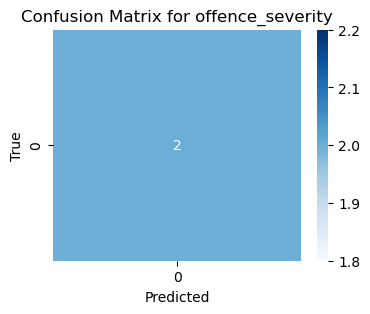

Model saved!


In [23]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast
#from model import MultiTaskActionRecognitionModel
#from data import load_filtered_clips_and_labels
from torchvision import transforms
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
torch.cuda.empty_cache()
import gc
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define parameters
batch_size = 2
num_epochs = 2
learning_rate = 0.001
max_samples = 1
fixed_frame_count = 16  # Standardized frame count for all clips
DATA_PATH = 'mvfouls'

# Transformation for preprocessing
transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class ActionDataset(Dataset):
    def __init__(self, clips, labels_action, labels_offence, labels_severity, labels_bodypart, labels_offence_severity):
        self.clips = clips
        self.labels_action = labels_action
        self.labels_offence = labels_offence
        self.labels_severity = labels_severity
        self.labels_bodypart = labels_bodypart
        self.labels_offence_severity = labels_offence_severity

    def __len__(self):
        return len(self.clips)

    def pad_or_truncate(self, clip):
        # Pad or truncate each clip to fixed frame count
        frames = []
        for i, frame in enumerate(clip):
            if not isinstance(frame, torch.Tensor):  # Ensure the frame is not already a tensor
                frame = transform(frame)  # Apply transforms
            frames.append(frame)
            if len(frames) == fixed_frame_count:  # Truncate
                break
        # Pad if necessary
        while len(frames) < fixed_frame_count:
            frames.append(torch.zeros_like(frames[0]))  # Padding with empty frames
        return torch.stack(frames)

    def __getitem__(self, idx):
        clip = self.clips[idx]
        padded_clip = self.pad_or_truncate(clip)
        return (padded_clip,
                self.labels_action[idx],
                self.labels_offence[idx],
                self.labels_severity[idx],
                self.labels_bodypart[idx],
                self.labels_offence_severity[idx])

# Load filtered dataset
train_clips, train_labels_action, train_labels_offence, train_labels_severity, train_labels_bodypart, train_labels_offence_severity = load_filtered_clips_and_labels(DATA_PATH, "train", max_samples=max_samples)
valid_clips, valid_labels_action, valid_labels_offence, valid_labels_severity, valid_labels_bodypart, valid_labels_offence_severity = load_filtered_clips_and_labels(DATA_PATH,"valid", max_samples=max_samples)

# Create Datasets and DataLoaders
train_dataset = ActionDataset(train_clips, train_labels_action, train_labels_offence, train_labels_severity, train_labels_bodypart, train_labels_offence_severity)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = ActionDataset(valid_clips, valid_labels_action, valid_labels_offence, valid_labels_severity, valid_labels_bodypart, valid_labels_offence_severity)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
print('Data loaded')

# Reshape the inputs to [batch_size, frames_clip_0 * frames_clip_1, channels, height, width]
def reshape_tensor(x):
    b, f0, f1, c, h, w = x.shape
    return x.view(b, f0*f1, c, h, w).permute(0, 2, 1, 3, 4)

# Initialize model, loss, and optimizer
model = MultiTaskActionRecognitionModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

accumulation_steps = 4  # Number of steps to accumulate gradients

# Function to calculate metrics
def calculate_metrics(predictions, labels):
    preds = predictions.argmax(dim=1).cpu().numpy()  # Convert logits to predicted class
    true = labels.cpu().numpy()  # Convert labels to numpy array
    f1 = f1_score(true, preds, average="macro")  # Macro F1 score for multi-class
    recall = recall_score(true, preds, average="macro")  # Macro recall
    accuracy = accuracy_score(true, preds)  # Accuracy
    return f1, recall, accuracy

def calculate_metrics_with_cm(predictions, labels, task_name):
    preds = predictions.argmax(dim=1).cpu().numpy()  # Convert logits to predicted class
    true = labels.cpu().numpy()  # Convert labels to numpy array
    
    # Metrics
    f1 = f1_score(true, preds, average="macro")
    recall = recall_score(true, preds, average="macro")
    accuracy = accuracy_score(true, preds)
    
    # Confusion Matrix
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {task_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    return f1, recall, accuracy


# Metrics storage
train_metrics = []
valid_metrics = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    train_loss = 0.0
    all_preds = {"action": [], "offence": [], "severity": [], "bodypart": [], "offence_severity": []}
    all_labels = {"action": [], "offence": [], "severity": [], "bodypart": [], "offence_severity": []}
    optimizer.zero_grad()  # Reset gradients at the beginning of each epoch

    for i, (inputs, action_labels, offence_labels, severity_labels, bodypart_labels, offence_severity_labels) in enumerate(train_loader):
        inputs = reshape_tensor(inputs).to(device)

        # Move labels to device
        action_labels = action_labels.to(device)
        offence_labels = offence_labels.to(device)
        severity_labels = severity_labels.to(device)
        bodypart_labels = bodypart_labels.to(device)
        offence_severity_labels = offence_severity_labels.to(device)

        # Forward pass
        action_out, offence_out, severity_out, bodypart_out, offence_severity_out = model(inputs)
        loss = (criterion(action_out, action_labels) +
                criterion(offence_out, offence_labels) +
                criterion(severity_out, severity_labels) +
                criterion(bodypart_out, bodypart_labels) +
                criterion(offence_severity_out, offence_severity_labels))

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        optimizer.zero_grad()  # Reset gradients for the next step
        train_loss += loss.item()

        # Collect predictions and true labels for metric calculation
        all_preds["action"].append(action_out)
        all_labels["action"].append(action_labels)
        all_preds["offence"].append(offence_out)
        all_labels["offence"].append(offence_labels)
        all_preds["severity"].append(severity_out)
        all_labels["severity"].append(severity_labels)
        all_preds["bodypart"].append(bodypart_out)
        all_labels["bodypart"].append(bodypart_labels)
        all_preds["offence_severity"].append(offence_severity_out)
        all_labels["offence_severity"].append(offence_severity_labels)

    # Compute metrics for the training epoch
    train_f1, train_recall, train_acc = {}, {}, {}
    for key in all_preds:
        f1, recall, acc = calculate_metrics(torch.cat(all_preds[key]), torch.cat(all_labels[key]))
        train_f1[key] = f1
        train_recall[key] = recall
        train_acc[key] = acc


    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}")
    print(f"Training Metrics: F1 {train_f1}, Recall {train_recall}, Accuracy {train_acc}")

    # Validation loop
    model.eval()
    valid_loss = 0.0
    all_preds = {"action": [], "offence": [], "severity": [], "bodypart": [], "offence_severity": []}
    all_labels = {"action": [], "offence": [], "severity": [], "bodypart": [], "offence_severity": []}

    with torch.no_grad():  # Disable gradient tracking for validation
        for inputs, action_labels, offence_labels, severity_labels, bodypart_labels, offence_severity_labels in valid_loader:
            inputs = reshape_tensor(inputs).to(device)
            action_labels = action_labels.to(device)
            offence_labels = offence_labels.to(device)
            severity_labels = severity_labels.to(device)
            bodypart_labels = bodypart_labels.to(device)
            offence_severity_labels = offence_severity_labels.to(device)

            action_out, offence_out, severity_out, bodypart_out, offence_severity_out = model(inputs)

            # Calculate validation loss
            loss = (criterion(action_out, action_labels) +
                    criterion(offence_out, offence_labels) +
                    criterion(severity_out, severity_labels) +
                    criterion(bodypart_out, bodypart_labels) +
                    criterion(offence_severity_out, offence_severity_labels))
            valid_loss += loss.item()

            # Collect predictions and true labels
            all_preds["action"].append(action_out)
            all_labels["action"].append(action_labels)
            all_preds["offence"].append(offence_out)
            all_labels["offence"].append(offence_labels)
            all_preds["severity"].append(severity_out)
            all_labels["severity"].append(severity_labels)
            all_preds["bodypart"].append(bodypart_out)
            all_labels["bodypart"].append(bodypart_labels)
            all_preds["offence_severity"].append(offence_severity_out)
            all_labels["offence_severity"].append(offence_severity_labels)

    # Compute metrics for the validation epoch
    valid_f1, valid_recall, valid_acc = {}, {}, {}
    for key in all_preds:
        f1, recall, acc = calculate_metrics(torch.cat(all_preds[key]), torch.cat(all_labels[key]))
        valid_f1[key] = f1
        valid_recall[key] = recall
        valid_acc[key] = acc

    print(f"Validation Loss: {valid_loss / len(valid_loader):.4f}")
    print(f"Validation Metrics: F1 {valid_f1}, Recall {valid_recall}, Accuracy {valid_acc}")

    # Store metrics
    train_metrics.append({"loss": train_loss / len(train_loader), "f1": train_f1, "recall": train_recall, "accuracy": train_acc})
    valid_metrics.append({"loss": valid_loss / len(valid_loader), "f1": valid_f1, "recall": valid_recall, "accuracy": valid_acc})

    # After each training epoch
    gc.collect()
    torch.cuda.empty_cache()

for key in all_preds:
    f1, recall, acc = calculate_metrics_with_cm(torch.cat(all_preds[key]), torch.cat(all_labels[key]), task_name=key)
    valid_f1[key] = f1
    valid_recall[key] = recall
    valid_acc[key] = acc

for key in all_preds:
    f1, recall, acc = calculate_metrics_with_cm(torch.cat(all_preds[key]), torch.cat(all_labels[key]), task_name=key)
    train_f1[key] = f1
    train_recall[key] = recall
    train_acc[key] = acc

# Save the model
os.makedirs("saved_models", exist_ok=True)
torch.save(model.state_dict(), "saved_models/resnet_model.pth")
print("Model saved!")

In [10]:
import torch
from sklearn.metrics import f1_score, recall_score, accuracy_score

def test_model(model, test_loader, criterion, device):
    """
    Function to test the MultiTaskActionRecognitionModel.
    
    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader for the test dataset.
        criterion: Loss function (e.g., CrossEntropyLoss).
        device: Device to run the testing on (CPU or GPU).

    Returns:
        Metrics for each task (loss, accuracy, F1-score, and recall).
    """
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0

    # Lists to store predictions and true labels for each task
    all_preds_action, all_labels_action = [], []
    all_preds_offence, all_labels_offence = [], []
    all_preds_severity, all_labels_severity = [], []
    all_preds_bodypart, all_labels_bodypart = [], []
    all_preds_offence_severity, all_labels_offence_severity = [], []

    with torch.no_grad():
        for inputs, action_labels, offence_labels, severity_labels, bodypart_labels, offence_severity_labels in test_loader:
            # Move data to the appropriate device
            

            # Reshape the inputs to [batch_size, frames_clip_0 * frames_clip_1, channels, height, width]
            def reshape_tensor(x):
                b, f0, f1, c, h, w = x.shape
                return x.view(b, f0*f1, c, h, w).permute(0, 2, 1, 3, 4)
            
            inputs = reshape_tensor(inputs).to(device)
            inputs = inputs.to(device)
            
            action_labels = action_labels.to(device)
            offence_labels = offence_labels.to(device)
            severity_labels = severity_labels.to(device)
            bodypart_labels = bodypart_labels.to(device)
            offence_severity_labels = offence_severity_labels.to(device)

            # Forward pass
            action_out, offence_out, severity_out, bodypart_out, offence_severity_out = model(inputs)

            # Calculate loss for each task
            loss_action = criterion(action_out, action_labels)
            loss_offence = criterion(offence_out, offence_labels)
            loss_severity = criterion(severity_out, severity_labels)
            loss_bodypart = criterion(bodypart_out, bodypart_labels)
            loss_offence_severity = criterion(offence_severity_out, offence_severity_labels)

            # Total loss for the batch
            loss = loss_action + loss_offence + loss_severity + loss_bodypart + loss_offence_severity
            test_loss += loss.item()

            # Convert predictions to class labels
            action_preds = torch.argmax(action_out, dim=1).cpu().numpy()
            offence_preds = torch.argmax(offence_out, dim=1).cpu().numpy()
            severity_preds = torch.argmax(severity_out, dim=1).cpu().numpy()
            bodypart_preds = torch.argmax(bodypart_out, dim=1).cpu().numpy()
            offence_severity_preds = torch.argmax(offence_severity_out, dim=1).cpu().numpy()

            # Append predictions and labels for metric calculation
            all_preds_action.extend(action_preds)
            all_labels_action.extend(action_labels.cpu().numpy())

            all_preds_offence.extend(offence_preds)
            all_labels_offence.extend(offence_labels.cpu().numpy())

            all_preds_severity.extend(severity_preds)
            all_labels_severity.extend(severity_labels.cpu().numpy())

            all_preds_bodypart.extend(bodypart_preds)
            all_labels_bodypart.extend(bodypart_labels.cpu().numpy())

            all_preds_offence_severity.extend(offence_severity_preds)
            all_labels_offence_severity.extend(offence_severity_labels.cpu().numpy())

    # Calculate average loss
    avg_loss = test_loss / len(test_loader)

    # Calculate metrics for each task
    def calculate_metrics(preds, labels):
        accuracy = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average='weighted')
        recall = recall_score(labels, preds, average='weighted')
        return accuracy, f1, recall

    metrics_action = calculate_metrics(all_preds_action, all_labels_action)
    metrics_offence = calculate_metrics(all_preds_offence, all_labels_offence)
    metrics_severity = calculate_metrics(all_preds_severity, all_labels_severity)
    metrics_bodypart = calculate_metrics(all_preds_bodypart, all_labels_bodypart)
    metrics_offence_severity = calculate_metrics(all_preds_offence_severity, all_labels_offence_severity)

    print("\nTest Metrics:")
    print(f"Overall Loss: {avg_loss:.4f}")
    print(f"Action - Accuracy: {metrics_action[0]:.4f}, F1: {metrics_action[1]:.4f}, Recall: {metrics_action[2]:.4f}")
    print(f"Offence - Accuracy: {metrics_offence[0]:.4f}, F1: {metrics_offence[1]:.4f}, Recall: {metrics_offence[2]:.4f}")
    print(f"Severity - Accuracy: {metrics_severity[0]:.4f}, F1: {metrics_severity[1]:.4f}, Recall: {metrics_severity[2]:.4f}")
    print(f"Bodypart - Accuracy: {metrics_bodypart[0]:.4f}, F1: {metrics_bodypart[1]:.4f}, Recall: {metrics_bodypart[2]:.4f}")
    print(f"Offence Severity - Accuracy: {metrics_offence_severity[0]:.4f}, F1: {metrics_offence_severity[1]:.4f}, Recall: {metrics_offence_severity[2]:.4f}")

    return {
        'loss': avg_loss,
        'metrics_action': metrics_action,
        'metrics_offence': metrics_offence,
        'metrics_severity': metrics_severity,
        'metrics_bodypart': metrics_bodypart,
        'metrics_offence_severity': metrics_offence_severity,
    }

# Example usage
if __name__ == "__main__":
    # Load test data
    test_clips, test_labels_action, test_labels_offence, test_labels_severity, test_labels_bodypart, test_labels_offence_severity = load_filtered_clips_and_labels(DATA_PATH, "test", max_samples=max_samples)
    test_dataset = ActionDataset(test_clips, test_labels_action, test_labels_offence, test_labels_severity, test_labels_bodypart, test_labels_offence_severity)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Load the trained model
    model = MultiTaskActionRecognitionModel().to(device)
    model.load_state_dict(torch.load("saved_models/action_recognition_model.pth"))

    # Define loss criterion
    criterion = nn.CrossEntropyLoss()

    # Evaluate the model
    test_results = test_model(model, test_loader, criterion, device)


Loading annotations from: mvfouls\test\annotations.json
Total actions found in annotations: 301
Action 0, Clip 0 tensor shape: torch.Size([16, 3, 56, 56])
Tensor size: 0.57 MB
Action 0, Clip 1 tensor shape: torch.Size([16, 3, 56, 56])
Tensor size: 0.57 MB
Added action 0 with 2 clips to dataset.
Action 6, Clip 0 tensor shape: torch.Size([16, 3, 56, 56])
Tensor size: 0.57 MB
Action 6, Clip 1 tensor shape: torch.Size([16, 3, 56, 56])
Tensor size: 0.57 MB
Added action 6 with 2 clips to dataset.

Summary:
Total actions loaded: 2
Total actions skipped: 0
Example clip shape: torch.Size([16, 3, 56, 56])
First action label: 0


C:\Users\harka\AppData\Local\Temp\ipykernel_29864\4209438815.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_models/action_reco


Test Metrics:
Overall Loss: 5.8270
Action - Accuracy: 0.0000, F1: 0.0000, Recall: 0.0000
Offence - Accuracy: 0.5000, F1: 0.3333, Recall: 0.5000
Severity - Accuracy: 1.0000, F1: 1.0000, Recall: 1.0000
Bodypart - Accuracy: 0.5000, F1: 0.3333, Recall: 0.5000
Offence Severity - Accuracy: 1.0000, F1: 1.0000, Recall: 1.0000


c:\Users\harka\miniconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
